# Notebook Setup

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    # MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/TFT_baseline"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    # MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling"

## Import Modules

In [3]:
required_packages = ['azure-storage-blob', 'kaleido']

for p in required_packages: 
    try:
         __import__(p)
    except ImportError:
          %pip install {p} --quiet

Note: you may need to restart the kernel to use updated packages.


In [266]:
import os
os.chdir(MY_HOME_ABS_PATH)

import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import kaleido
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.express.colors import sample_colorscale
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio


from timeit import default_timer
from datetime import datetime
import gc
import pickle


# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

Global seed set to 42


42

## Define Local File System Constants

In [279]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
img_dir = data_dir + os.sep + 'figures'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'
model_objects_dir = root_dir + os.sep + 'code/src/modeling/model_objects'

# Load Eval Data from Azure Storage Blob

In [6]:
container_name = "model-eval"
blob_name = "val_raw_predictions_best_GPP_TFT_april4.pkl"
local_file = tmp_dir + os.sep + blob_name

In [7]:
raw_predictions = None
print(local_file)
if not (os.path.exists(local_file)):
    azStorageClient = AzStorageClient(az_cred_file)
    file_stream = azStorageClient.downloadBlob2Stream(container_name, blob_name)
    file_stream.seek(0)    # move back to the beginning after writing
    raw_predictions = pickle.load(file_stream)
    with open(local_file, 'wb') as handle:
        pickle.dump(raw_predictions, handle)
else:
     with open(local_file, 'rb') as handle:
            raw_predictions  = pickle.load(handle)
            
raw_predictions.keys()

/root/co2-flux-hourly-gpp-modeling/.tmp/val_raw_predictions_best_GPP_TFT_april4.pkl


dict_keys(['prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths'])

In [8]:
model_path = f"{MY_HOME_ABS_PATH}/data/models/tft_model_1yrtrain_tuning_230318_1906/trial_0/epoch=12.ckpt"
model = TemporalFusionTransformer.load_from_checkpoint(model_path)
print(f"Quantiles: {model.loss.quantiles}")

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]


### Define TS Dataset(two types)

In [9]:
# Use this instead!!
def setup_tsdataset(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=["year", "month", "day", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=["GPP_NT_VUT_REF"],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            'year': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

In [10]:
def setup_tsdataset_nogpp_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)


# setup datasets data
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
training, validation, _ = setup_tsdataset_nogpp_slim(train_df, val_df, None, ENCODER_LEN)

NameError: name 'data_df' is not defined

Setup batch size

In [ ]:
# create dataloaders for model
batch_size = 64
cpu_count = os.cpu_count()

## Create TS Dataset

In [ ]:
# Experiment constants
VAL_INDEX = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365 # 1 year
ENCODER_LEN =  24*7
print(f"training timestemp length= {SUBSET_LEN}")

# Setup dataset
train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, test_df = subset_data(train_df, val_df, test_df, SUBSET_LEN)

### GPP-TFT

In [ ]:
(training_GPP, validation_GPP, testing_GPP) = setup_tsdataset(train_df, val_df, test_df, ENCODER_LEN)

In [ ]:
# # Get small test data
# subtest_df = test_df.loc[test_df['timestep_idx_local'] < ENCODER_LEN+5, ].copy()
# _, _, subtesting = setup_tsdataset(train_df, val_df, subtest_df, ENCODER_LEN)
# print(f"Subset num subtest timesteps: {len(subtest_df)}")

# # create dataloaders for model
# # ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
# batch_size = 64  # set this between 32 to 128
# cpu_count = os.cpu_count()

### Define TS Dataset for NO-PAST-GPP models

In [ ]:
# (training_NO_PAST_GPP, validation_NO_PAST_GPP, testing_NO_PAST_GPP) = setup_tsdataset_no_past_GPP(train_df, val_df, test_df, ENCODER_LEN)


In [ ]:
# # Get small test data
# subtest_df = test_df.loc[test_df['timestep_idx_local'] < ENCODER_LEN+5, ].copy()
# _, _, subtesting = setup_tsdataset(train_df, val_df, subtest_df, ENCODER_LEN)
# print(f"Subset num subtest timesteps: {len(subtest_df)}")

# # create dataloaders for model
# # ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
# batch_size = 64  # set this between 32 to 128
# cpu_count = os.cpu_count()

In [ ]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=cpu_count, pin_memory=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count, pin_memory=False)

# # Create TFT model from dataset
# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=0.00001,
#     hidden_size=16,  # most important hyperparameter apart from learning rate
#     attention_head_size=1, # Set to up to 4 for large datasets
#     dropout=0.3, # Between 0.1 and 0.3 are good values
#     hidden_continuous_size=16,  # set to <= hidden_size
#     output_size=7,  # 7 quantiles by default
#     loss=QuantileLoss(),
#     logging_metrics=nn.ModuleList([MAE(), RMSE()]),
#     reduce_on_plateau_patience=2, # reduce learning rate if no improvement in validation loss after x epochs
#     optimizer="adam"
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# # configure network and trainer
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=6, mode="min", check_finite=True, verbose=False,)
# lr_logger = LearningRateMonitor()  # log the learning rate
# checkpoint_callback = ModelCheckpoint(dirpath=exp_model_dir, save_top_k=3, monitor="val_loss") # save model objects for top k epoch val loss
# logger = TensorBoardLogger(exp_model_dir)  # logging results to a tensorboard

# trainer = pl.Trainer(
#     max_epochs=25,
#     enable_model_summary=True,
#     #gradient_clip_val=2,
#     fast_dev_run=False, 
#     accelerator='gpu',
#     devices="auto", 
#     callbacks=[lr_logger, early_stop_callback],
#     logger=logger,
#     strategy="ddp",
# )

## Prepare Two Validation Data Loaders

In [ ]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
# Eval on Validation set
val_dataloader_GPP = validation_GPP.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

# Print Model Eval on Validation Set
val_actuals_GPP = torch.cat([y[0] for x, y in iter(val_dataloader_GPP)])

In [ ]:
# Eval on Validation set
val_dataloader_GPP = validation_GPP.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

# Print Model Eval on Validation Set
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader_GPP)])


In [ ]:
# save eval results - also we can resume eval at a later point in time

with open("val_actuals_best_GPP_TFT_April8.pkl", "wb") as fout:
    pickle.dump(val_actuals_GPP, fout)

In [ ]:
!pwd

In [ ]:
# import boto3
# import json
# from io import StringIO
# create an S3 client
# s3_client = boto3.client('s3')

# bucket_name = 'rumi-store-prediction-result'
# file_name = "val_actuals_best_GPP_TFT_April8.pkl"

# # upload the file to S3
# s3_client.upload_file(file_name, bucket_name,
#                       "/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling")

In [ ]:
# create a large dictionary
# my_dict = {...}  # your large dictionary here

# serialize the dictionary to a JSON-formatted string
# json_string = json.dumps(my_dict)

# # create a StringIO buffer to hold the JSON string in memory
# buffer = StringIO(json_string)

# # upload the buffer to S3
# bucket_name = 'your-bucket-name'
# file_name = 'your-file-name.json'
# s3_client.put_object(Body=buffer.getvalue(), Bucket=bucket_name, Key=file_name)

# Model Interpretation

### Interpret_output
- reduction: "none" for no averaging over batches, 
- "sum" for summing attentions, 
- "mean" for normalizing by encode lengths
- attention_prediction_horizon: which prediction horizon to use for attention

When encoder length is 24 times 7, Each feature has 168 feature importance in each prediction time point

## Create df importance of the snapshot of one prediction time point

In [11]:
# Get encoder variable names
encoder_var = model.encoder_variables
print(f'encoder variables({len(model.encoder_variables)}): {model.encoder_variables}')

encoder variables(38): ['year', 'month', 'day', 'hour', 'gap_flag_month', 'gap_flag_hour', 'timestep_idx_global', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 'relative_time_idx', 'GPP_NT_VUT_REF']


In [12]:
ENCODER_LEN =raw_predictions['encoder_lengths'][0].item()

# tensor to list
encoder_size_importance = []
for i in raw_predictions['encoder_variables'][0]:
    encoder_size_importance += [list(i.numpy()[0])]

# define encoder index -1 to -168
print(f"Encoder Length: {ENCODER_LEN}")
encoder_size_importance_df = pd.DataFrame(encoder_size_importance,columns=encoder_var)
encoder_index = [-(ENCODER_LEN-i) for i in range(168)]

encoder_size_importance_df["encoder_index"] = encoder_index
columns_order = list(encoder_size_importance_df.columns[-1:]) + list(encoder_size_importance_df.columns[:-1])
encoder_size_imp_df  = encoder_size_importance_df[columns_order]
display(encoder_size_imp_df.head())


Encoder Length: 168


encoder_index    year   month     day    hour  gap_flag_month  \
0           -168 0.01975 0.01695 0.00222 0.00744         0.00867   
1           -167 0.01967 0.01688 0.00222 0.00720         0.00839   
2           -166 0.01965 0.01684 0.00224 0.00722         0.00836   
3           -165 0.01978 0.01690 0.00223 0.00730         0.00845   
4           -164 0.01989 0.01698 0.00222 0.00741         0.00865   

   gap_flag_hour  timestep_idx_global  TA_ERA  SW_IN_ERA  LW_IN_ERA  VPD_ERA  \
0        0.09434              0.02045 0.02397    0.12294    0.02738  0.02498   
1        0.09022              0.02021 0.02308    0.12234    0.02741  0.02498   
2        0.09447              0.02021 0.02340    0.12397    0.02717  0.02483   
3        0.09356              0.02040 0.02418    0.12409    0.02712  0.02486   
4        0.09416              0.02054 0.02482    0.12471    0.02719  0.02493   

    P_ERA  PA_ERA     EVI    NDVI    NIRv      b1      b2      b3      b4  \
0 0.00461 0.02564 0.01595 0.02031 0.00123 0.02050 0.02651 0.00482 0.01342   
1 0.00473 0.02531 0.01532 0.02019 0.00122 0.02040 0.02758 0.00473 0.01351   
2 0.00474 0.02558 0.01553 0.02023 0.00125 0.02042 0.02707 0.00484 0.01328   
3 0.00468 0.02597 0.01578 0.02040 0.00125 0.02057 0.02720 0.00486 0.01343   
4 0.00463 0.02614 0.01606 0.02050 0.00126 0.02067 0.02727 0.00489 0.01360   

       b5      b6      b7  BESS-PAR  BESS-PARdiff  BESS-RSDN  CSIF-SIFdaily  \
0 0.02235 0.02409 0.01167   0.02168       0.00579    0.02226        0.00626   
1 0.02228 0.02402 0.01178   0.02053       0.00584    0.02217        0.00627   
2 0.02222 0.02390 0.01176   0.02126       0.00578    0.02215        0.00617   
3 0.02236 0.02392 0.01160   0.02157       0.00584    0.02232        0.00633   
4 0.02245 0.02399 0.01149   0.02202       0.00582    0.02246        0.00639   

      PET      Ts  ESACCI-sm    NDWI  Percent_Snow    Fpar     Lai  LST_Day  \
0 0.02067 0.00586    0.03573 0.02106       0.00171 0.02094 0.00585  0.01984   
1 0.02059 0.00560    0.03566 0.02098       0.00171 0.02111 0.00577  0.01975   
2 0.02058 0.00591    0.03647 0.02096       0.00170 0.02054 0.00574  0.01975   
3 0.02075 0.00587    0.03659 0.02111       0.00171 0.02083 0.00575  0.01991   
4 0.02088 0.00597    0.03677 0.02124       0.00171 0.02097 0.00578  0.02004   

   LST_Night  relative_time_idx  GPP_NT_VUT_REF  
0    0.00442            0.02968         0.21806  
1    0.00444            0.02957         0.22633  
2    0.00438            0.02953         0.21989  
3    0.00440            0.02974         0.21639  
4    0.00437            0.02992         0.21121

In [13]:
encoder_size_imp_df.columns

Index(['encoder_index', 'year', 'month', 'day', 'hour', 'gap_flag_month',
       'gap_flag_hour', 'timestep_idx_global', 'TA_ERA', 'SW_IN_ERA',
       'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1',
       'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'BESS-PAR', 'BESS-PARdiff',
       'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 'ESACCI-sm', 'NDWI',
       'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night',
       'relative_time_idx', 'GPP_NT_VUT_REF'],
      dtype='object')

### Choose average top 20 features to plot

In [14]:
encoder_size_imp_rank_df = pd.DataFrame(encoder_size_imp_df.sum()/ENCODER_LEN, columns=['avg_encoder_imp'])
encoder_size_imp_rank_df = encoder_size_imp_rank_df.sort_values(by=['avg_encoder_imp'], ascending=False)
encoder_size_imp_rank_df[:15]

avg_encoder_imp
GPP_NT_VUT_REF               0.15492
SW_IN_ERA                    0.13039
gap_flag_hour                0.06532
b4                           0.04536
ESACCI-sm                    0.03250
year                         0.03163
BESS-RSDN                    0.03103
relative_time_idx            0.03099
timestep_idx_global          0.03057
LW_IN_ERA                    0.02829
PA_ERA                       0.02790
b2                           0.02699
VPD_ERA                      0.02678
b6                           0.02576
TA_ERA                       0.02503

# Create stack area plot

In [15]:
encoder_size_imp_rank_df[:15].index

Index(['GPP_NT_VUT_REF', 'SW_IN_ERA', 'gap_flag_hour', 'b4', 'ESACCI-sm',
       'year', 'BESS-RSDN', 'relative_time_idx', 'timestep_idx_global',
       'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA'],
      dtype='object')

color palette in seaborn https://seaborn.pydata.org/generated/seaborn.color_palette.html

Examples
- `pal = sns.light_palette("seagreen")`
- `pal = sns.color_palette("mako")`
- `pal = sns.cubehelix_palette(start=.5, rot=-.75)#, as_cmap=True)`
- `pal = sns.cubehelix_palette(start=.5, rot=-.5)#, as_cmap=True)`


In [265]:
# Compute Attention
encoder_size_imp_df["encoder_attention"] = list(raw_predictions["encoder_attention"][0][0][0].numpy())
encoder_size_imp_df.head()

encoder_index    year   month     day    hour  gap_flag_month  \
0           -168 0.01975 0.01695 0.00222 0.00744         0.00867   
1           -167 0.01967 0.01688 0.00222 0.00720         0.00839   
2           -166 0.01965 0.01684 0.00224 0.00722         0.00836   
3           -165 0.01978 0.01690 0.00223 0.00730         0.00845   
4           -164 0.01989 0.01698 0.00222 0.00741         0.00865   

   gap_flag_hour  timestep_idx_global  TA_ERA  SW_IN_ERA  LW_IN_ERA  VPD_ERA  \
0        0.09434              0.02045 0.02397    0.12294    0.02738  0.02498   
1        0.09022              0.02021 0.02308    0.12234    0.02741  0.02498   
2        0.09447              0.02021 0.02340    0.12397    0.02717  0.02483   
3        0.09356              0.02040 0.02418    0.12409    0.02712  0.02486   
4        0.09416              0.02054 0.02482    0.12471    0.02719  0.02493   

    P_ERA  PA_ERA     EVI    NDVI    NIRv      b1      b2      b3      b4  \
0 0.00461 0.02564 0.01595 0.02031 0.00123 0.02050 0.02651 0.00482 0.01342   
1 0.00473 0.02531 0.01532 0.02019 0.00122 0.02040 0.02758 0.00473 0.01351   
2 0.00474 0.02558 0.01553 0.02023 0.00125 0.02042 0.02707 0.00484 0.01328   
3 0.00468 0.02597 0.01578 0.02040 0.00125 0.02057 0.02720 0.00486 0.01343   
4 0.00463 0.02614 0.01606 0.02050 0.00126 0.02067 0.02727 0.00489 0.01360   

       b5      b6      b7  BESS-PAR  BESS-PARdiff  BESS-RSDN  CSIF-SIFdaily  \
0 0.02235 0.02409 0.01167   0.02168       0.00579    0.02226        0.00626   
1 0.02228 0.02402 0.01178   0.02053       0.00584    0.02217        0.00627   
2 0.02222 0.02390 0.01176   0.02126       0.00578    0.02215        0.00617   
3 0.02236 0.02392 0.01160   0.02157       0.00584    0.02232        0.00633   
4 0.02245 0.02399 0.01149   0.02202       0.00582    0.02246        0.00639   

      PET      Ts  ESACCI-sm    NDWI  Percent_Snow    Fpar     Lai  LST_Day  \
0 0.02067 0.00586    0.03573 0.02106       0.00171 0.02094 0.00585  0.01984   
1 0.02059 0.00560    0.03566 0.02098       0.00171 0.02111 0.00577  0.01975   
2 0.02058 0.00591    0.03647 0.02096       0.00170 0.02054 0.00574  0.01975   
3 0.02075 0.00587    0.03659 0.02111       0.00171 0.02083 0.00575  0.01991   
4 0.02088 0.00597    0.03677 0.02124       0.00171 0.02097 0.00578  0.02004   

   LST_Night  relative_time_idx  GPP_NT_VUT_REF  encoder_attention  
0    0.00442            0.02968         0.21806            0.00419  
1    0.00444            0.02957         0.22633            0.00024  
2    0.00438            0.02953         0.21989            0.00010  
3    0.00440            0.02974         0.21639            0.00013  
4    0.00437            0.02992         0.21121            0.00039

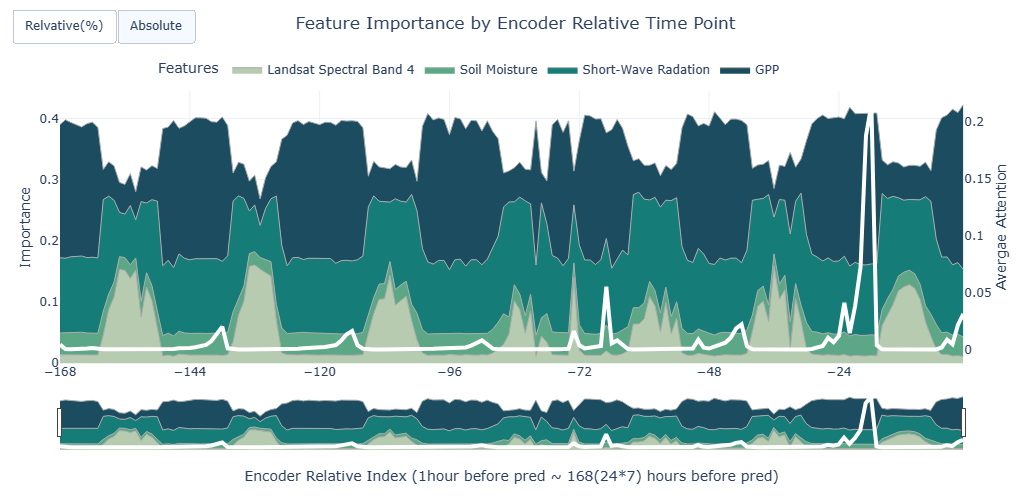

In [284]:
plot_df = encoder_size_imp_df

features=['b4', 'ESACCI-sm','SW_IN_ERA','GPP_NT_VUT_REF',] #TODO: Put in preferred order
xticks = [i for i in range(-ENCODER_LEN, 1, 24)]

readable_feature_names = {
    'GPP_NT_VUT_REF': 'GPP',
    'SW_IN_ERA': 'Short-Wave Radation',
    'ESACCI-sm': 'Soil Moisture', 
    'b4': 'Landsat Spectral Band 4',
}

# Select color scale from: https://plotly.com/python/builtin-colorscales/#builtin-sequential-color-scales
colors = sample_colorscale('tempo', np.linspace(0.2, 0.8, len(features)))

# Plot feature importance time-series
fig = make_subplots(specs=[[{"secondary_y": True}]])
for i,  f in enumerate(features):
    fig.add_trace( 
        go.Scatter( x=plot_df['encoder_index'], y=plot_df[f],
                   name=f, mode='lines',
                   line_color = '#AAA', line_width = 1,
                   fillcolor =  colors[i],
                   stackgroup='one' , # define stack group
                   hovertemplate = '%{y:.4f}'
                  ),
        secondary_y=False,
    )
    
# Update lengend name to readable feature  names
fig.for_each_trace(lambda t: t.update(name = readable_feature_names[t.name],
                                      legendgroup = readable_feature_names[t.name],
                                      #hovertemplate = t.hovertemplate.replace(t.name, readable_feature_names[t.name])
                 )
)

# Add attention line
fig.add_trace(
    go.Scatter(
        x=plot_df['encoder_index'], y=plot_df['encoder_attention'],
        mode='lines', line_color = 'white', line_width = 4,
        name = 'Average Attention',
       # hovertemplate = '%{y:.4f}',
        showlegend = False,
    ),
    secondary_y=True
)

# Other formattings stuff

# Available plotly template/theme: https://plotly.com/python/templates/
# ['ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff', 'ygridoff', 'gridon', 'none']
fig.update_layout(title={'text': "Feature Importance by Encoder Relative Time Point", 'y':0.965,'x':0.5},
                  margin={"r":10,"t":75,"l":60,"b":50},
                  height = 500, width = 1000,
                  legend={ 'title':{'text' :"Features"}, 'orientation':"h", 'x': 0.1, 'y':1.025, 'itemwidth':30,},
                  hovermode="x unified", # or just "x"
                  template='plotly_white')
fig.update_xaxes(title={'text': "Encoder Relative Index (1hour before pred ~ 168(24*7) hours before pred)", 
                        'font_size': 14, 'standoff': 0}, tickvals=xticks,
                 rangeslider_visible=True, # show time sliders
                )
fig.update_yaxes(title={'text': "Importance",  'font_size': 14, 'standoff':0}, secondary_y=False)
fig.update_yaxes(title={'text': "Avergae Attention",  'font_size': 14, 'standoff':0}, showgrid=False, secondary_y=True)


# y-scaling button (removable)
showToggle = True
if showToggle:
    fig.update_layout(
        updatemenus=[
            dict(
                type = "buttons",
                direction = "left",
                buttons=list([
                    dict(
                        args=[{"groupnorm": "percent"}],
                        label="Relvative(%)",
                        method="restyle"
                    ),
                    dict(
                         args=[{"groupnorm": ""},],
                        label="Absolute",
                        method="restyle"
                    )
                ]),
                pad={"l": 0, "t": 0},
                active=1,
                x=-0.05, xanchor="left",
                y=1.3,
              # font_color='gray' # For dark backgroun only
            ),
        ]
    )

# For Dark backgroun
# fig.update_layout(font = dict(color = 'white'), paper_bgcolor="rgba(0,0,0,0)", )
    
fig.show()

# Export to HTML
file_name = img_dir + os.sep + "FeatureImportance_plot.html" # TODO: Update name if there are multiple plots
pio.write_html(fig, file = file_name, include_plotlyjs = 'cdn')

# Reference Plots

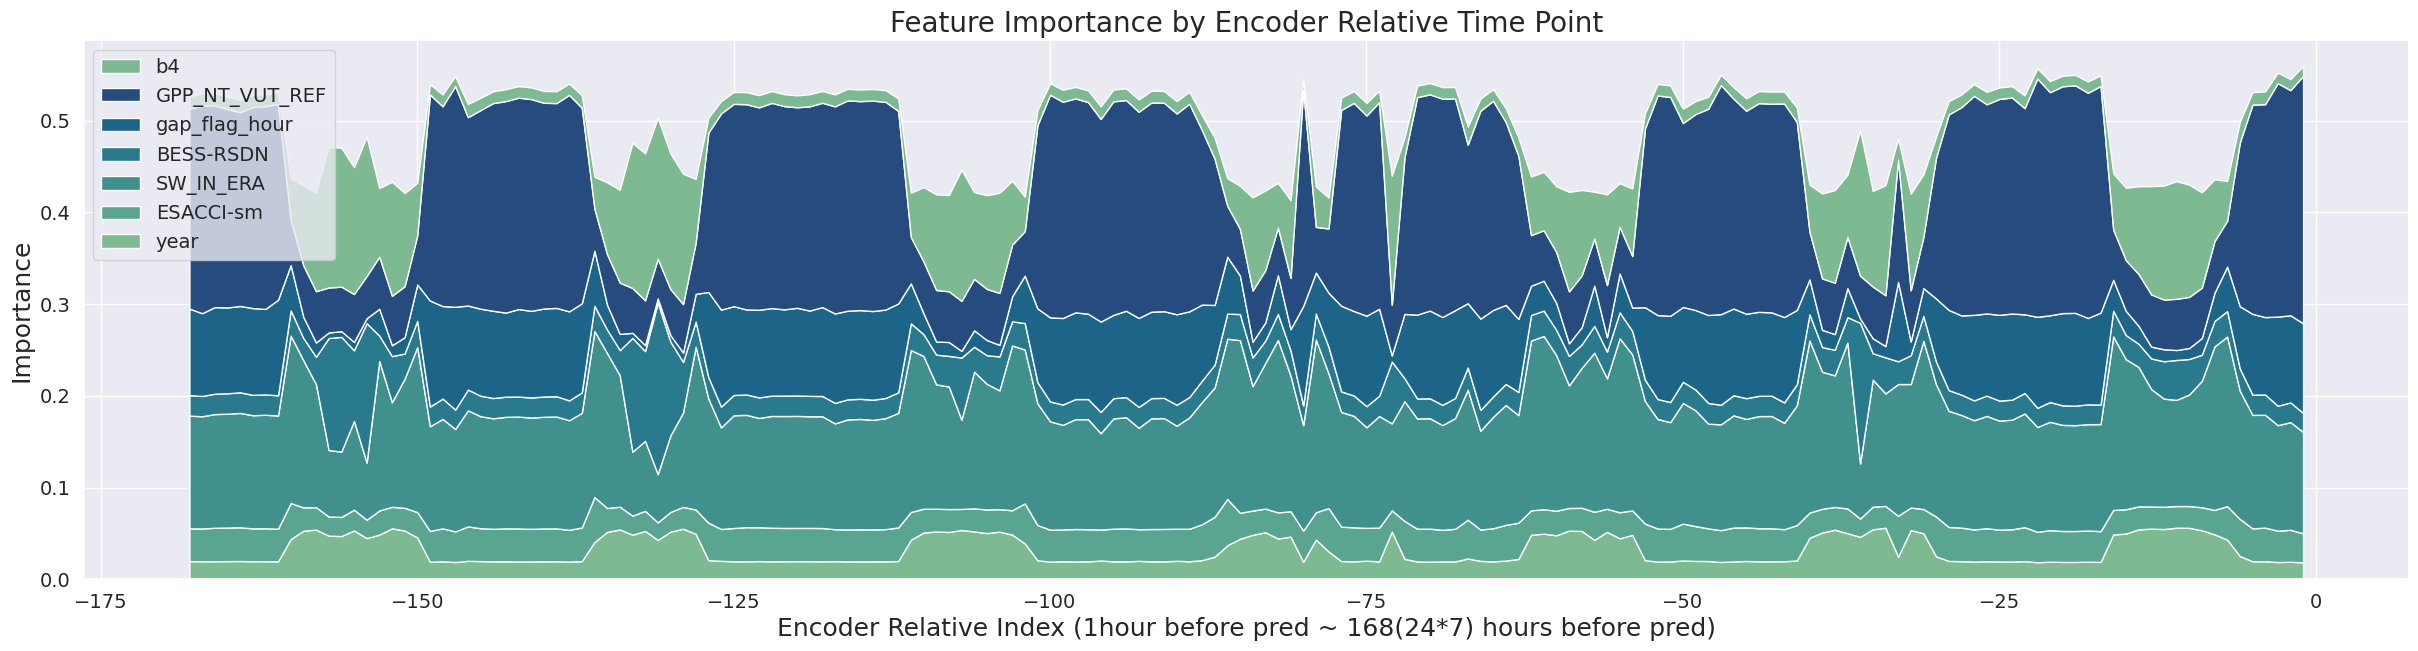

In [366]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn style
sns.set_theme()
pal = sns.color_palette("crest")
sns.set(rc={'figure.figsize':(30,7), })

#['GPP_NT_VUT_REF', 'SW_IN_ERA', 'gap_flag_hour', 'b4', 'ESACCI-sm',
       # 'year', 'BESS-RSDN', 'relative_time_idx', 'timestep_idx_global',
       # 'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA']

#create area chart
plt.stackplot(encoder_size_imp_df['encoder_index'], # x axis
              encoder_size_imp_df['year'],
              encoder_size_imp_df['ESACCI-sm'],
              encoder_size_imp_df['SW_IN_ERA'],
              encoder_size_imp_df['BESS-RSDN'],
              encoder_size_imp_df['gap_flag_hour'],
              encoder_size_imp_df['GPP_NT_VUT_REF'],
              encoder_size_imp_df['b4'],
              labels=['year','ESACCI-sm','SW_IN_ERA','BESS-RSDN','gap_flag_hour','GPP_NT_VUT_REF','b4'],
              colors=pal)

labels=['year','ESACCI-sm','SW_IN_ERA','BESS-RSDN','gap_flag_hour','GPP_NT_VUT_REF','b4']
# Reverse the order of labels in legend
plt.legend(reversed(plt.legend().legendHandles), reversed(labels), loc='upper left', fontsize=14)

#add axis labels
plt.title('Feature Importance by Encoder Relative Time Point', fontsize=20)
plt.ylabel('Importance', fontsize=18)
plt.xlabel('Encoder Relative Index (1hour before pred ~ 168(24*7) hours before pred)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14) # fontsize of both axes


## Add attention to the plot 

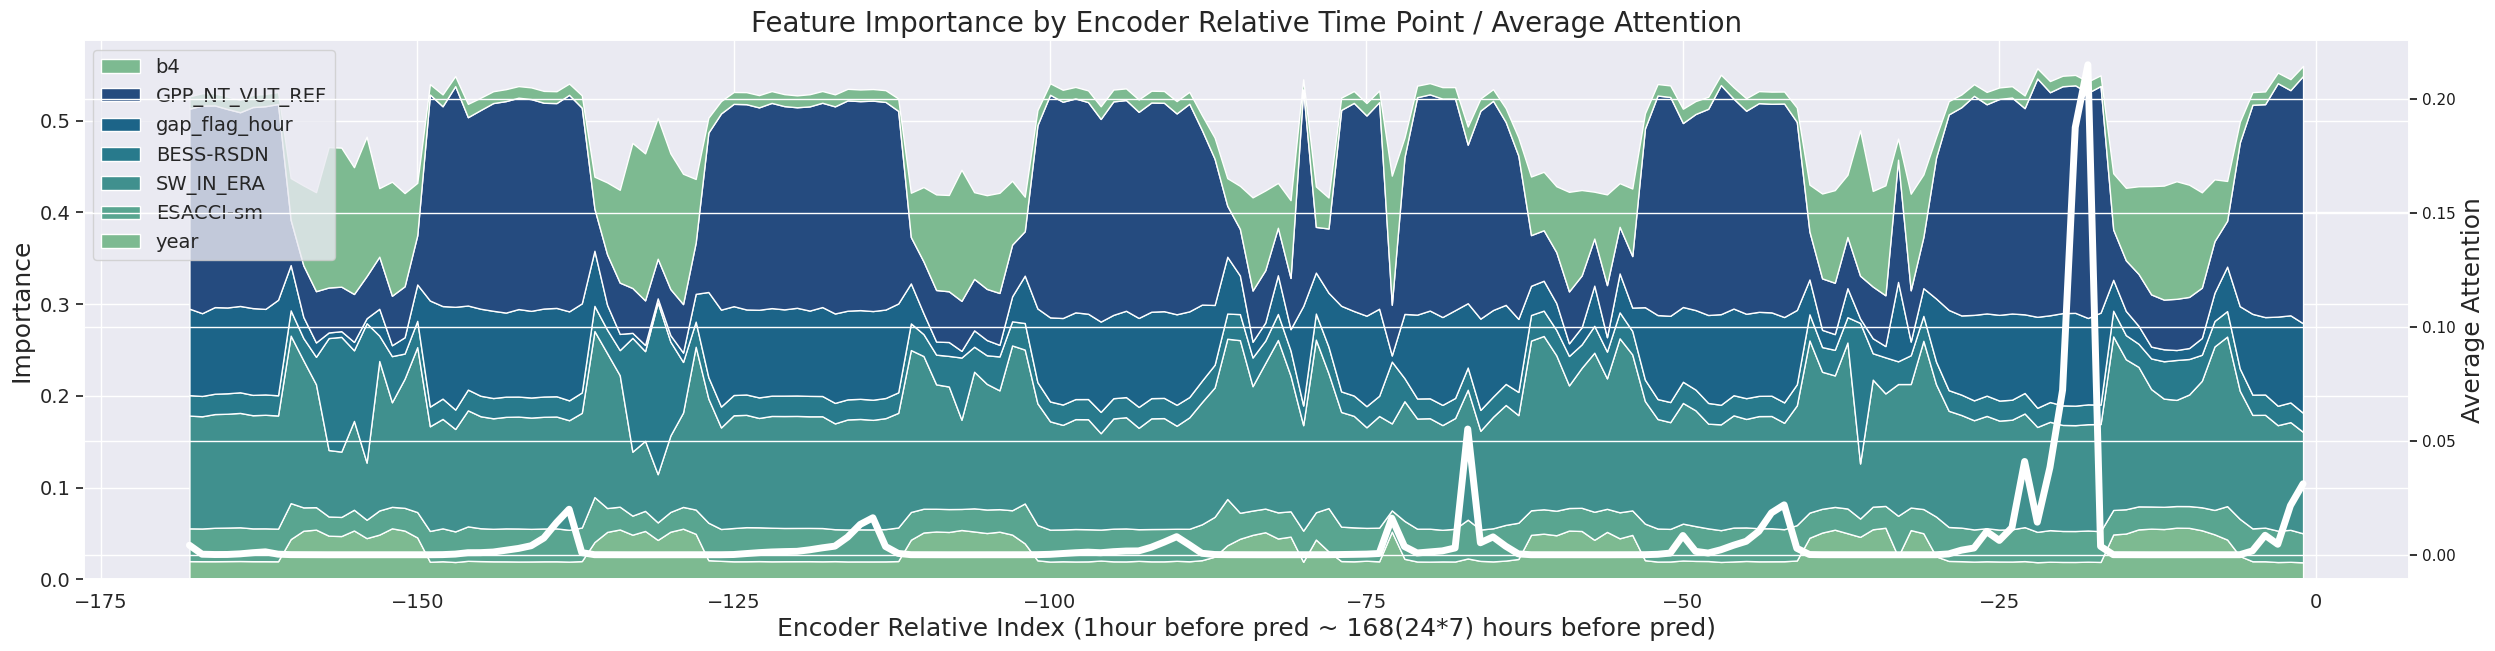

<Figure size 3000x700 with 0 Axes>

In [456]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn style
sns.set_theme()
pal = sns.color_palette("crest")
sns.set(rc={'figure.figsize':(30,7)})

#['GPP_NT_VUT_REF', 'SW_IN_ERA', 'gap_flag_hour', 'b4', 'ESACCI-sm',
       # 'year', 'BESS-RSDN', 'relative_time_idx', 'timestep_idx_global',
       # 'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA']

#create area chart
plt.stackplot(encoder_size_imp_df['encoder_index'], # x axis
              encoder_size_imp_df['year'],
              encoder_size_imp_df['ESACCI-sm'],
              encoder_size_imp_df['SW_IN_ERA'],
              encoder_size_imp_df['BESS-RSDN'],
              encoder_size_imp_df['gap_flag_hour'],
              encoder_size_imp_df['GPP_NT_VUT_REF'],
              encoder_size_imp_df['b4'],
              labels=['year','ESACCI-sm','SW_IN_ERA','BESS-RSDN','gap_flag_hour','GPP_NT_VUT_REF','b4'],
              colors=pal)

labels=['year','ESACCI-sm','SW_IN_ERA','BESS-RSDN','gap_flag_hour','GPP_NT_VUT_REF','b4']
# Reverse the order of labels in legend
plt.legend(reversed(plt.legend().legendHandles), reversed(labels), loc='upper left', fontsize=14)

#add axis labels
plt.title('Feature Importance by Encoder Relative Time Point / Average Attention', fontsize=20)
plt.ylabel('Importance', fontsize=18)
plt.xlabel('Encoder Relative Index (1hour before pred ~ 168(24*7) hours before pred)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14) # fontsize of both axes

plt2 = plt.twinx()

plt2.plot(encoder_size_imp_df["encoder_index"], encoder_size_imp_df["encoder_attention"], color='w', linewidth=5)
plt2.set_ylabel('Average Attention', fontsize=18)
plt2.tick_params('y', colors='k')
plt.show()
plt.savefig('fi_avg_attention_GPP_TFT_AU-DaP_78_20100108_0AM_0.png')

### (with different palette)

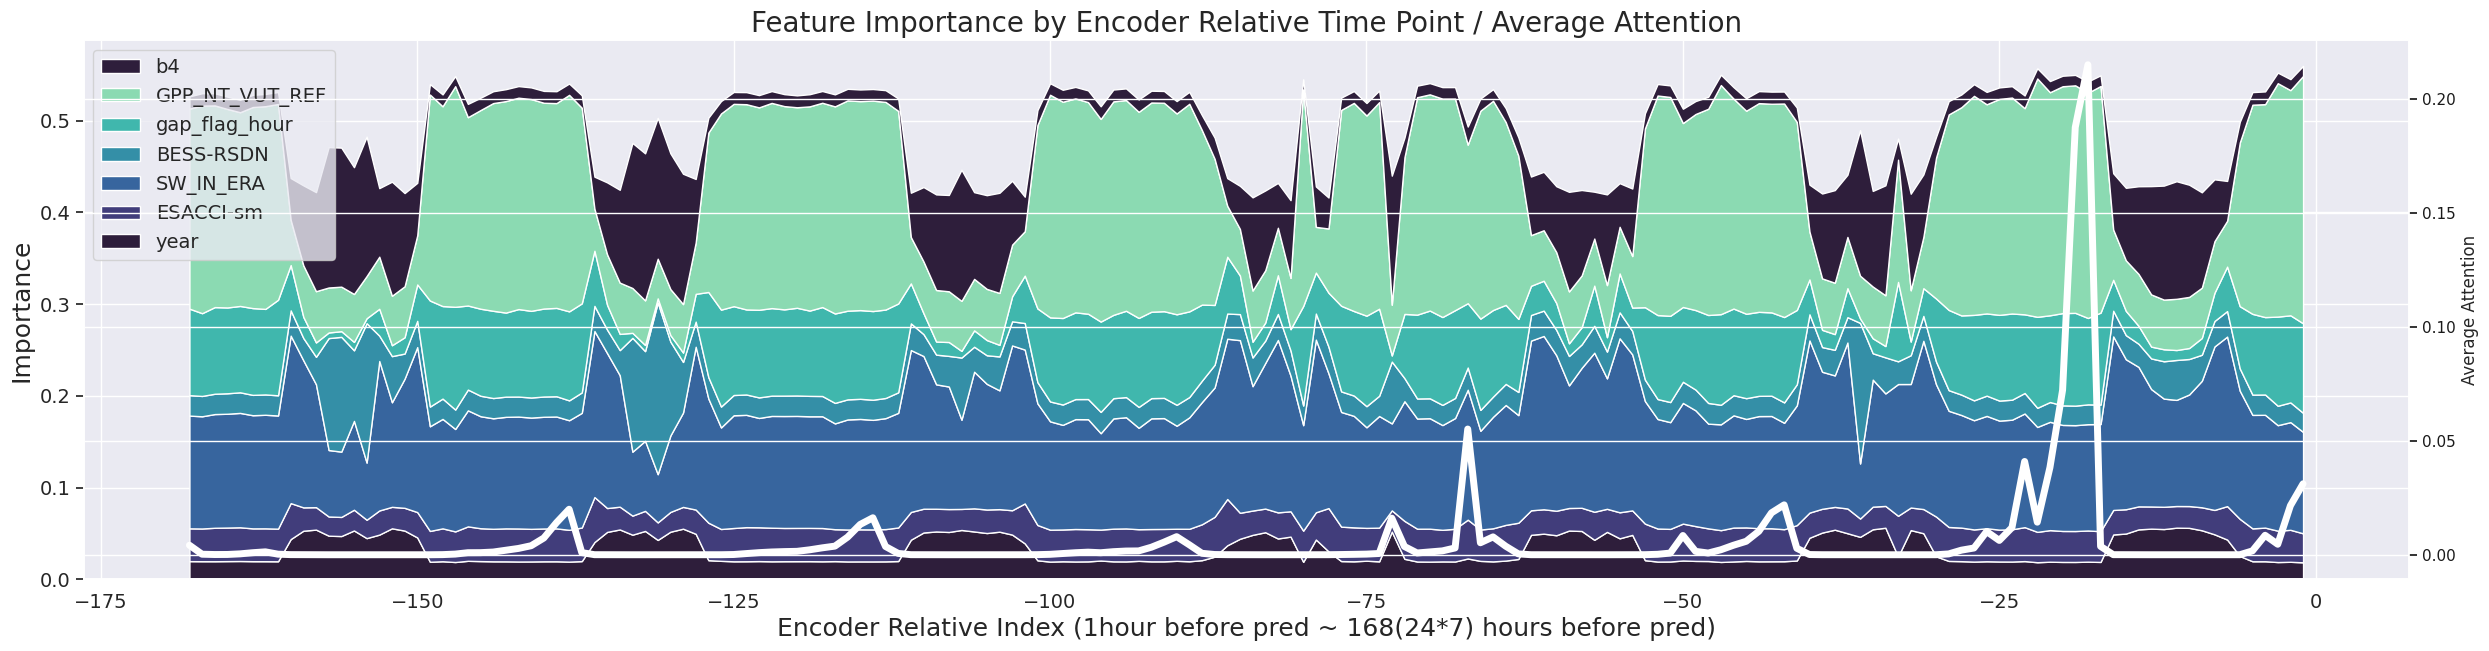

<Figure size 3000x700 with 0 Axes>

In [457]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn style
sns.set_theme()
# pal = sns.light_palette("seagreen")
pal = sns.color_palette("mako")
# pal = sns.cubehelix_palette(start=.5, rot=-.75)#, as_cmap=True)`
# pal = sns.cubehelix_palette(start=.5, rot=-.5)#, as_cmap=True)`
# pal = sns.color_palette("crest")
sns.set(rc={'figure.figsize':(30,7)})

#['GPP_NT_VUT_REF', 'SW_IN_ERA', 'gap_flag_hour', 'b4', 'ESACCI-sm',
       # 'year', 'BESS-RSDN', 'relative_time_idx', 'timestep_idx_global',
       # 'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA']

#create area chart
plt.stackplot(encoder_size_imp_df['encoder_index'], # x axis
              encoder_size_imp_df['year'],
              encoder_size_imp_df['ESACCI-sm'],
              encoder_size_imp_df['SW_IN_ERA'],
              encoder_size_imp_df['BESS-RSDN'],
              encoder_size_imp_df['gap_flag_hour'],
              encoder_size_imp_df['GPP_NT_VUT_REF'],
              encoder_size_imp_df['b4'],
              labels=['year','ESACCI-sm','SW_IN_ERA','BESS-RSDN','gap_flag_hour','GPP_NT_VUT_REF','b4'],
              colors=pal)

labels=['year','ESACCI-sm','SW_IN_ERA','BESS-RSDN','gap_flag_hour','GPP_NT_VUT_REF','b4']
# Reverse the order of labels in legend
plt.legend(reversed(plt.legend().legendHandles), reversed(labels), loc='upper left', fontsize=14)

#add axis labels
plt.title('Feature Importance by Encoder Relative Time Point / Average Attention', fontsize=20)
plt.ylabel('Importance', fontsize=18)
plt.xlabel('Encoder Relative Index (1hour before pred ~ 168(24*7) hours before pred)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14) # fontsize of both axes

plt2 = plt.twinx()

plt2.plot(encoder_size_imp_df["encoder_index"], encoder_size_imp_df["encoder_attention"], color='w', linewidth=5)
plt2.set_ylabel('Average Attention')
plt2.tick_params('y', colors='k')# black is k
plt.show()

plt.savefig('fi_avg_attention_GPP_TFT_AU-DaP_78_20100108_0AM.png')

## Plot without GPP

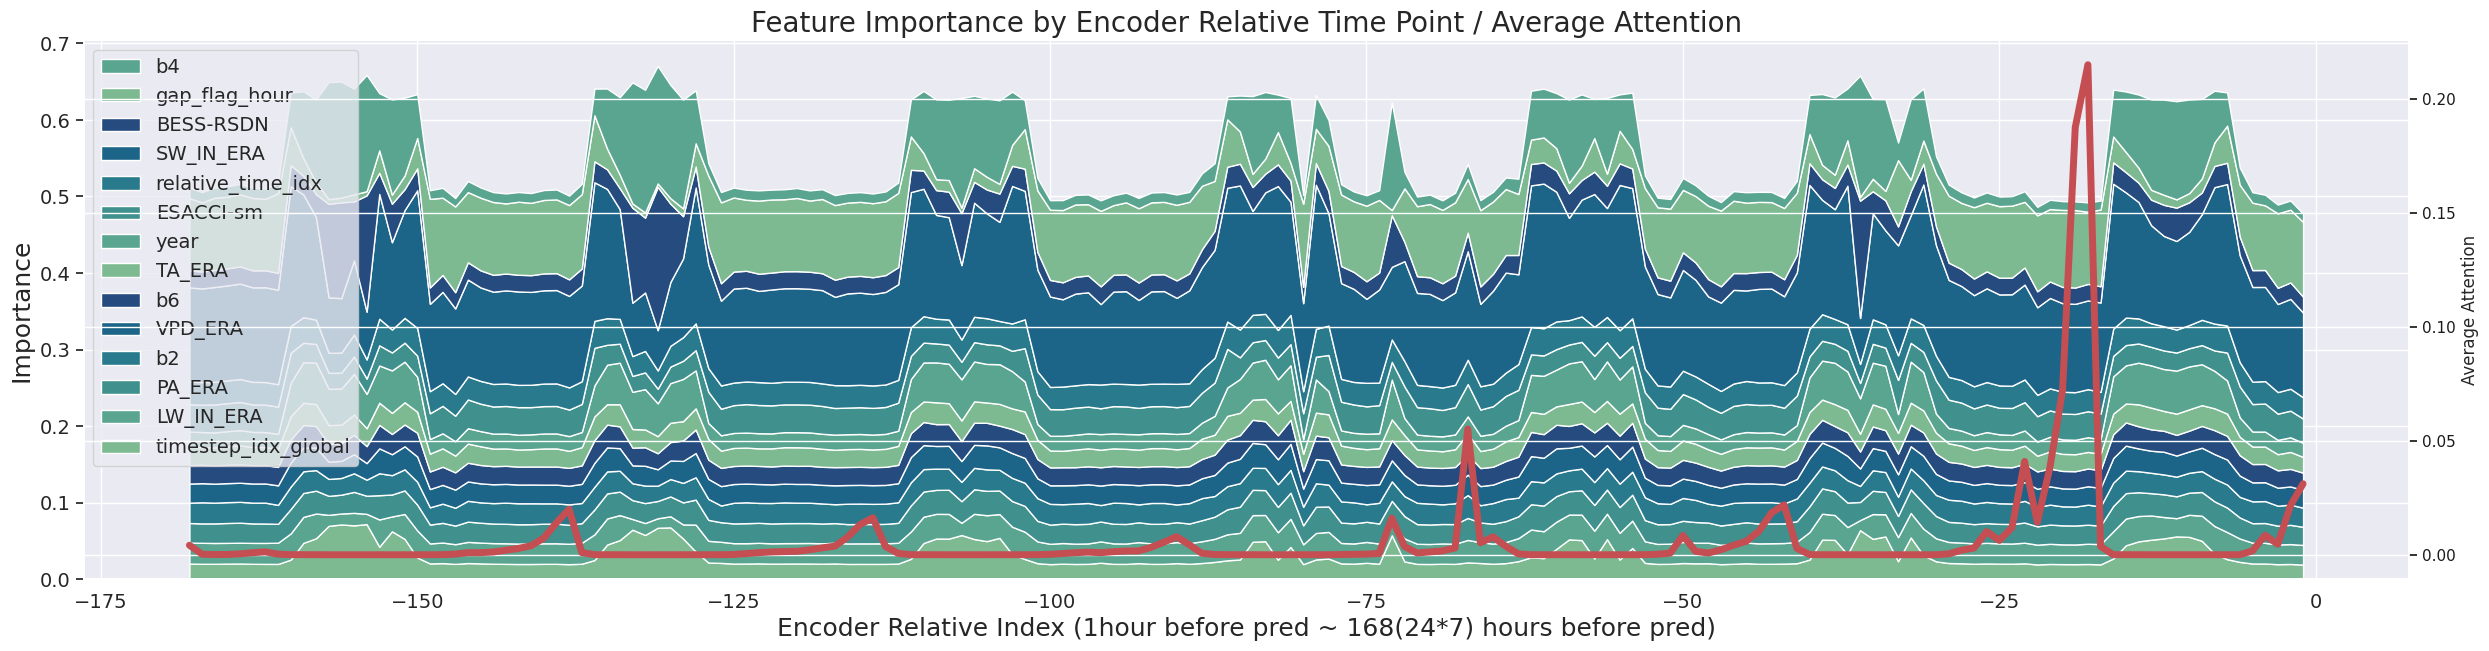

<Figure size 3000x700 with 0 Axes>

In [458]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn style
sns.set_theme()
# pal = sns.light_palette("seagreen")
# pal = sns.color_palette("mako")
# pal = sns.cubehelix_palette(start=.5, rot=-.75)#, as_cmap=True)`
# pal = sns.cubehelix_palette(start=.5, rot=-.5)#, as_cmap=True)`
pal = sns.color_palette("crest")
sns.set(rc={'figure.figsize':(30,7)})

#['GPP_NT_VUT_REF', 'SW_IN_ERA', 'gap_flag_hour', 'b4', 'ESACCI-sm',
       # 'year', 'BESS-RSDN', 'relative_time_idx', 'timestep_idx_global',
       # 'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA']

#create area chart
plt.stackplot(encoder_size_imp_df['encoder_index'], # x axis
              encoder_size_imp_df['timestep_idx_global'],
              encoder_size_imp_df['LW_IN_ERA'],
              encoder_size_imp_df['PA_ERA'],
              encoder_size_imp_df['b2'],
              encoder_size_imp_df['VPD_ERA'],
              encoder_size_imp_df['b6'],
              encoder_size_imp_df['TA_ERA'],
              encoder_size_imp_df['year'],
              encoder_size_imp_df['ESACCI-sm'],
              encoder_size_imp_df['relative_time_idx'],
              encoder_size_imp_df['SW_IN_ERA'],
              encoder_size_imp_df['BESS-RSDN'],
              encoder_size_imp_df['gap_flag_hour'],
              encoder_size_imp_df['b4'], 
              labels=['timestep_idx_global', 'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA',
                      'year','ESACCI-sm','relative_time_idx', 'SW_IN_ERA','BESS-RSDN','gap_flag_hour','b4'],
              colors=pal)

labels=['timestep_idx_global', 'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA',
        'year','ESACCI-sm','relative_time_idx', 'SW_IN_ERA','BESS-RSDN','gap_flag_hour','b4']
# Reverse the order of labels in legend
plt.legend(reversed(plt.legend().legendHandles), reversed(labels), loc='upper left', fontsize=14)

#add axis labels
plt.title('Feature Importance by Encoder Relative Time Point / Average Attention', fontsize=20)
plt.ylabel('Importance', fontsize=18)
plt.xlabel('Encoder Relative Index (1hour before pred ~ 168(24*7) hours before pred)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14) # fontsize of both axes

plt2 = plt.twinx()

plt2.plot(encoder_size_imp_df["encoder_index"], encoder_size_imp_df["encoder_attention"], color='r', linewidth=5)
plt2.set_ylabel('Average Attention')
plt2.tick_params('y', colors='k')# black is k
plt.show()

plt.savefig('fi_avg_attention_GPP_TFT_AU-DaP_78_20100108_0AM_2.png')